In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

import yfinance as yf
import numpy as np
import pandas as pd
import calendar
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from cvxpy import *
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4359    0  4359    0     0  27764      0 --:--:-- --:--:-- --:--:-- 27764
100  517k  100  517k    0     0  1097k      0 --:--:-- --:--:-- --:--:-- 1097k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4347    0  4347    0     0  27000      0 --:--:-- --:--:-- --:--:-- 27168
100  392k  100  392k    0     0  1078k      0 --:--:-- --:--:-- --:--:-- 11.5M


## Get Price data and construct technical indicators

In [ ]:
def construct_tech (tick, start, end):
  target_data = yf.download(tick, start = start, end = end)
  target_data.columns = ['open','high','low','close','adj_close','volumn']
  target_data['MA_10'] = talib.MA(target_data['close'] , timeperiod = 10)
  target_data['MA_30'] = talib.MA(target_data['close'] , timeperiod = 30)
  target_data['STOCHRSI_k'],target_data['STOCHRSI_d'] =  talib.STOCHRSI(target_data['close'])
  target_data['RSI_6'] =  talib.RSI(target_data['close'], timeperiod = 6)
  target_data['RSI_9'] =  talib.RSI(target_data['close'], timeperiod = 9)
  target_data['MACD'],target_data['MACD_signal'],target_data['MACD_hist'] =  talib.MACD(target_data['close'])
  target_data['B_up'], target_data['B_mid'],target_data['B_low'] = talib.BBANDS(target_data['close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
  target_data['KDJ_kf'],target_data['KDJ_df'] = talib.STOCHF(target_data['high'],target_data['low'],target_data['close'])
  target_data['ATR'] = talib.NATR(target_data['high'],target_data['low'],target_data['close'], timeperiod=14)
  target_data['SAR'] = talib.SAR(target_data['high'],target_data['low'])
  target_data['SAR_if'] = (target_data['close'] > target_data['SAR']).astype(int)

  target_data['ROC_MA_10'] = talib.ROC(target_data['MA_10'], timeperiod=1)
  target_data['ROC_MA_30'] = talib.ROC(target_data['MA_30'], timeperiod=1)

  target_data['MA_10_out'] = target_data['close'] - target_data['MA_10']
  target_data['MA_30_out'] = target_data['close']  - target_data['MA_30']

  target_data['RSI_dif'] = target_data['RSI_6'] - target_data['RSI_9']
  target_data['MACD_dif'] = target_data['MACD'] - target_data['MACD_signal']
  target_data['KDJ_diff_f'] = target_data['KDJ_kf'] - target_data['KDJ_df']

  target_data['B_up_diff'] = target_data['B_up'] - target_data['close']
  target_data['B_mid_diff'] = target_data['B_mid'] - target_data['close']
  target_data['B_low_diff'] =  target_data['close'] - target_data['B_low']

  target_data['log_close'] = np.log(target_data['close'])
  target_data['log_high'] = np.log(target_data['high'])
  target_data['log_low'] = np.log(target_data['low'])
  target_data['log_open'] = np.log(target_data['open'])
  target_data['vola_log_close'] = target_data['log_close'].rolling(window=5).std()
  target_data = target_data.dropna()

  target_data['log_vol'] = np.log(target_data['volumn'])
  target_data['log_MA_10'] = np.log(target_data['MA_10'])
  target_data['log_MA_30'] = np.log(target_data['MA_30'])

  target_data['return'] = target_data['close'].pct_change(periods = 1)*100
  target_data['return_vola'] = target_data['return'].rolling(window=5).std()

  target_data = target_data.dropna()

  target_data = target_data[['return',
        'STOCHRSI_k', 'STOCHRSI_d', 'RSI_6', 'RSI_9', 'MACD', 'MACD_signal',
        'MACD_hist', 'KDJ_kf', 'KDJ_df', 'ATR',
        'SAR_if', 'ROC_MA_10', 'ROC_MA_30', 'MA_10_out', 'MA_30_out', 'RSI_dif',
        'MACD_dif', 'KDJ_diff_f', 'B_up_diff', 'B_mid_diff', 'B_low_diff',
        'log_close', 'vola_log_close', 'log_vol', 'log_MA_10', 'log_MA_30','return_vola']]

  return target_data

In [ ]:
startDate = '2010-01-01'
endDate = '2022-12-31'
tickers = ['GLD','IBB','XLK','USO','AAPL']
get_price_and_technical_of_5_tickers = {}
for ticker in tickers:
  get_price_and_technical_of_5_tickers[ticker] = construct_tech(ticker,startDate,endDate)
get_price_and_technical_of_5_tickers['AAPL'].head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,return,STOCHRSI_k,STOCHRSI_d,RSI_6,RSI_9,MACD,MACD_signal,MACD_hist,KDJ_kf,KDJ_df,ATR,SAR_if,ROC_MA_10,ROC_MA_30,MA_10_out,MA_30_out,RSI_dif,MACD_dif,KDJ_diff_f,B_up_diff,B_mid_diff,B_low_diff,log_close,vola_log_close,log_vol,log_MA_10,log_MA_30,return_vola
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-01,2.135676,100.000000,100.000000,75.154741,66.635348,-0.025740,-0.089439,0.063700,96.301776,91.488816,2.314861,1,0.427150,-0.007293,0.234286,0.281941,8.519394,0.063700,4.812960,0.059331,-0.225858,0.511047,2.010082,0.021981,20.125599,1.978190,1.971576,1.518498
2010-03-02,-0.066990,97.878624,99.292875,74.367097,66.202327,-0.004785,-0.072509,0.067723,85.796326,92.094717,2.256635,1,0.269229,0.048402,0.209822,0.273465,8.164769,0.067723,-6.298390,0.108139,-0.136643,0.381425,2.009412,0.018684,20.155070,1.980878,1.972060,0.889167
2010-03-03,0.229816,100.000000,99.292875,75.426588,67.028687,0.013054,-0.055396,0.068450,89.239447,90.445850,2.156499,1,0.334030,-0.094603,0.202749,0.297404,8.397901,0.068450,-1.206403,0.118059,-0.091856,0.301772,2.011707,0.015965,19.734546,1.984213,1.971114,0.881966
2010-03-04,0.659249,100.000000,99.292875,78.493594,69.445153,0.030813,-0.038154,0.068967,97.645684,90.893819,2.066977,1,0.382022,-0.016916,0.224250,0.347904,9.048440,0.068967,6.751865,0.067422,-0.078928,0.225278,2.018278,0.011047,19.718256,1.988026,1.970944,0.882422
2010-03-05,3.910595,100.000000,100.000000,88.646711,79.525224,0.067852,-0.016953,0.084805,94.736817,93.873983,2.140387,1,0.845273,0.180460,0.456822,0.629238,9.121488,0.084805,0.862835,0.004061,-0.270857,0.545775,2.056639,0.020107,20.617483,1.996443,1.972747,1.651586


## Get factors like VIX, USDX, M1, CCI, unemployment, EFFR


In [ ]:
# 恐慌指数VIX
VIX = yf.download('^VIX',start = startDate,end = endDate).resample("D").ffill()
VIX = VIX['Adj Close'].rename('VIX')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 美元汇率指数USDX
USDX = yf.download('DX-Y.NYB',start = startDate,end = endDate).resample("D").ffill()
log_USDX = np.log(USDX['Adj Close']).rename('log_USDX')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 美国失业率指数
unemployment = pd.read_excel('unemployment.xlsx')
unemployment["Date"] = pd.to_datetime(unemployment["release_Date"].apply(lambda x : x[:-6]), format="%d %b %Y")
unemployment['unemployment'] = unemployment['unemployment'].apply(lambda x : x[:-1])
unemployment['unemployment'] = unemployment['unemployment'].astype(float)
unemployment.set_index('Date',inplace=True)
unemployment = unemployment.resample("D").ffill()

In [ ]:
# 美国消费者信心调查
CCI = pd.read_excel('CCI.xlsx')
CCI["Date"] = pd.to_datetime(CCI["release_Date"].apply(lambda x : x[:-6]), format="%d %b %Y")
CCI['CCI'] = CCI['CCI'] - 100
CCI.set_index('Date',inplace=True)
CCI = CCI.resample("D").ffill()

In [ ]:
# 美元基础利率（美联储每日利率）
EFFR = pd.read_csv('EFFR.csv')
EFFR["Date"] = pd.to_datetime(EFFR["DATE"], format="%Y/%m/%d")
EFFR.set_index('Date',inplace=True)
EFFR = EFFR.resample("D").ffill()
EFFR['EFFR'] = EFFR['EFFR'].str.replace(".",'0.0')

In [ ]:
# 美元M1货币供给
M1 = pd.read_csv('M1.csv')
new_row = pd.Series(['Apr-23', None], index=M1.columns)
M1.loc[len(M1)] = new_row
M1['month'] = pd.to_datetime(M1['month'], format="%b-%y")
M1['Date'] = M1['month'].apply(lambda x : datetime(x.year,x.month,calendar.monthrange(x.year,x.month)[1]))
M1['log_M1']=np.log(M1['M1']).shift(1)
M1.set_index('Date',inplace=True)
M1 = M1.resample("D").ffill()

In [ ]:
# target_data = target_data.join(VIX).join(log_USDX).join(unemployment['unemployment']).join(CCI['CCI']).join(EFFR['EFFR']).join(M1['log_M1'])
# target_data = target_data.apply(pd.to_numeric)
# target_data = target_data.dropna()
# backtest_data = target_data.loc['2021-12-31':]
# target_data = target_data.loc[:'2021-12-31']
# target_data
technical_and_macre = {}
backtesting = {}
for ticker in tickers:
  temp = get_price_and_technical_of_5_tickers[ticker].join(VIX).join(log_USDX).join(unemployment['unemployment']).join(CCI['CCI']).join(EFFR['EFFR']).join(M1['log_M1'])
  technical_and_macre[ticker] = temp.apply(pd.to_numeric).dropna().loc['2010-01-01':'2021-12-31',:]
  backtesting[ticker] = temp.apply(pd.to_numeric).dropna().loc['2022-01-01':'2022-12-31',:]
backtesting['AAPL'].head(20)

,return,STOCHRSI_k,STOCHRSI_d,RSI_6,RSI_9,MACD,MACD_signal,MACD_hist,KDJ_kf,KDJ_df,ATR,SAR_if,ROC_MA_10,ROC_MA_30,MA_10_out,MA_30_out,RSI_dif,MACD_dif,KDJ_diff_f,B_up_diff,B_mid_diff,B_low_diff,log_close,vola_log_close,log_vol,log_MA_10,log_MA_30,return_vola,VIX,log_USDX,unemployment,CCI,EFFR,log_M1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-03,2.500415,100.000000,3.333333e+01,70.998281,67.990779,4.818780,4.982143,-0.163363,84.519417,48.202085,2.239032,1,0.617413,0.473027,4.865994,11.095327,3.007501,-0.163363,36.317332,0.320130,-2.719995,5.760120,5.204062,0.009448,18.464582,5.176963,5.141164,1.319055,16.600000,4.566845,4.2,15.8,0.008,9.916236
2022-01-04,-1.269160,10.227490,3.674250e+01,58.694286,60.442633,4.672654,4.920245,-0.247591,42.957729,46.404750,2.257668,1,0.561690,0.373481,1.560997,8.146997,-1.748347,-0.247591,-3.447021,2.729771,-0.327997,3.385765,5.191289,0.009505,18.413761,5.182564,5.144892,1.449870,16.910000,4.567364,4.2,15.8,0.008,9.916236
2022-01-05,-2.659988,0.000000,3.674250e+01,41.035650,48.029823,4.123607,4.760917,-0.637310,3.373478,43.616875,2.379512,1,0.108342,0.270082,-3.412001,2.903665,-6.994173,-0.637310,-40.243397,8.252919,3.560001,1.132918,5.164329,0.014701,18.364508,5.183647,5.147589,1.891117,19.730000,4.566325,4.2,15.8,0.008,9.916236
2022-01-06,-1.669334,0.000000,3.409163e+00,33.620758,42.089527,3.413516,4.491437,-1.077921,3.185845,16.505684,2.399051,0,-0.204114,0.205213,-5.967999,-0.369333,-8.468769,-1.077921,-13.319839,12.268703,5.239999,1.788704,5.147494,0.022208,18.389231,5.181604,5.149639,1.966427,19.610001,4.566949,4.2,15.8,0.008,9.916236
2022-01-07,0.098836,1.488656,4.962188e-01,34.448263,42.554861,2.831837,4.159517,-1.327680,9.571780,5.377035,2.354516,0,-0.230940,0.197831,-5.387001,-0.540335,-8.106598,-1.327680,4.194746,12.065510,3.989999,4.085511,5.148482,0.025538,18.278069,5.179292,5.151616,1.995980,18.760000,4.561636,3.9,15.8,0.008,9.916236
2022-01-10,0.011619,2.291609,1.260089e+00,34.563454,42.615903,2.345430,3.796700,-1.451270,27.217353,13.324993,2.365701,0,-0.458444,0.296836,-4.552997,-1.032998,-8.052449,-1.451270,13.892360,7.923380,2.005997,3.911387,5.148599,0.018820,18.486146,5.174697,5.154580,1.168246,19.400000,4.564244,3.9,15.8,0.008,9.916236
2022-01-11,1.678378,100.000000,3.459342e+01,49.843313,51.066884,2.168154,3.470990,-1.302836,57.583364,31.457499,2.338339,0,-0.238198,0.285566,-1.241998,1.362335,-1.223571,-1.302836,26.125865,1.018711,-1.808002,4.634714,5.165243,0.009105,18.148062,5.172312,5.157431,1.688065,18.410000,4.560382,3.9,15.8,0.008,9.916236
2022-01-12,0.257024,100.000000,6.743054e+01,51.940196,52.297496,2.040452,3.184883,-1.144431,81.687071,55.495929,2.261783,0,-0.218351,0.196295,-0.407001,1.471332,-0.357301,-1.144431,26.191142,1.000384,-2.135999,5.272381,5.167810,0.010092,18.130398,5.170126,5.159392,1.188617,17.620001,4.553877,3.9,15.8,0.008,9.916236
2022-01-13,-1.902807,0.000000,6.666667e+01,37.847358,43.221281,1.650709,2.878048,-1.227339,44.617167,61.295867,2.341326,0,-0.341599,0.142098,-3.145998,-2.115997,-5.373923,-1.227339,-16.678700,4.313841,1.241998,1.829845,5.148599,0.009883,18.252331,5.166704,5.160812,1.275686,20.309999,4.551664,3.9,15.8,0.008,9.916236


In [ ]:
all_actual_return ={}
for ticker in tickers:
  all_actual_return[ticker] = technical_and_macre[ticker].loc['2020-01-01':'2021-12-31','return']
all_actual_return = pd.DataFrame(all_actual_return)
all_actual_return

,GLD,IBB,XLK,USO,AAPL
Date,,,,,
2020-01-02,0.734782,-0.514482,1.876297,0.000000,2.281632
2020-01-03,1.326852,-1.276169,-1.124321,2.888367,-0.972204
2020-01-06,1.048950,0.642111,0.238251,-0.151749,0.796825
2020-01-07,0.393515,0.025184,-0.043216,-0.227961,-0.470305
2020-01-08,-0.750152,0.898027,1.070045,-3.579591,1.608629
...,...,...,...,...,...
2021-12-27,0.236725,-0.853324,2.145248,2.616223,2.297483
2021-12-28,-0.431007,-0.762860,-0.520803,0.275124,-0.576725
2021-12-29,-0.029651,0.413932,0.085363,0.749961,0.050204


In [ ]:
cov = all_actual_return.cov()
cov

,GLD,IBB,XLK,USO,AAPL
GLD,1.125389,0.307323,0.383359,0.035524,0.421346
IBB,0.307323,3.143711,2.582854,1.699812,2.508104
XLK,0.383359,2.582854,3.938428,2.414924,4.189877
USO,0.035524,1.699812,2.414924,12.005371,2.330837
AAPL,0.421346,2.508104,4.189877,2.330837,5.570713


## Supporting functions

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import time
import math
from sklearn.metrics import precision_score
from sklearn.metrics import precision_score
from tensorflow.python.client import device_lib
from keras.models import load_model
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17318707449614196191
 xla_global_id: -1]

In [ ]:
def DatasetCreation(dataset, time_step = 5):
   DataX, DataY = [], []
   for i in range(dataset.shape[0] - time_step -1):
     a = dataset.iloc[i:(i+ time_step),:]
     DataX.append(a)
     DataY.append(dataset.iloc[i + time_step, 0])
   return  np.asarray(DataX).astype('float32'), np.asarray(DataY).astype('float32')

In [ ]:
def build_model(hidden_1_nodes, hidden_2_nodes, num_features, drop=0.3, time_step=5, learning_rate = 0.001, verbose = 1):

  model = Sequential()
  model.add(LSTM(hidden_1_nodes, input_shape = (time_step, num_features), return_sequences=True))
  model.add(Dropout(drop))
  model.add(LSTM(hidden_2_nodes))
  model.add(Dense(1, activation = 'linear'))

  opt = optimizers.Adam(learning_rate = learning_rate)

  model.compile(loss='mean_squared_error', optimizer= opt)

  if verbose == 1:
    print(model.summary())
  return model

In [ ]:
def create_objective(target_data):

  def objective(trial):

    params = {
        'hidden_1_nodes': trial.suggest_int('hidden_1_nodes', 8, 32),
        'drop': trial.suggest_float("drop", 0.2, 0.5),
        'hidden_2_nodes': trial.suggest_int('hidden_2_nodes', 8, 32),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.1,0.01,0.005]),
        'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16]),
        'epoch': trial.suggest_int('epoch', 20, 50)
    }
    train_size = int(len(target_data) * (0.8))
    train_data, test_data = target_data[:train_size].dropna(), target_data[train_size:].dropna()
    num_features = train_data.shape[1]
    time_step = 5

    X_train, y_train  =   DatasetCreation(train_data, time_step)
    X_test, y_test    =   DatasetCreation(test_data, time_step)

    model = build_model(params['hidden_1_nodes'], params['hidden_2_nodes'],
              num_features, params['drop'], 5, params['learning_rate'],1)
    start = time.time()
    model.fit(X_train, y_train, batch_size = params['batch_size'], epochs= params['epoch'], verbose = 1)

    end = time.time()
    elapsed_time = end - start
    print('\n use time',elapsed_time)


    test_pred  =  model.predict(X_test).ravel()

    MSR =  mean_squared_error(y_test,test_pred)

    return MSR

  return objective

In [ ]:
# 不要跑这个格子！！！！否则会花费2小时用于调参

best_paramters = {}
for ticker in tickers:
  study = optuna.create_study(direction='minimize')
  objective = create_objective(technical_and_macre[ticker])
  study.optimize(objective, n_trials= 10)
  best_paramters[ticker] = study.best_params


[I 2023-05-24 05:14:59,360] A new study created in memory with name: no-name-b078921b-2474-4dca-bbd5-9e72c7922eea


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 13)             2496      
                                                                 
 dropout (Dropout)           (None, 5, 13)             0         
                                                                 
 lstm_1 (LSTM)               (None, 18)                2304      
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 4,819
Trainable params: 4,819
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/32


[W 2023-05-24 05:15:07,549] Trial 0 failed with parameters: {'hidden_1_nodes': 13, 'drop': 0.3581624821449253, 'hidden_2_nodes': 18, 'learning_rate': 0.01, 'batch_size': 4, 'epoch': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-25-c66dd4c1a342>", line 24, in objective
    model.fit(X_train, y_train, batch_size = params['batch_size'], epochs= params['epoch'], verbose = 1)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwarg

KeyboardInterrupt: ignored

In [ ]:
# 也不要跑这个格子！！！！

for ticker in tickers:
  print(best_paramters[ticker])

In [ ]:
# record the best hyper parameters
final_para={
   'GLD': {'hidden_1_nodes': 17, 'drop': 0.41, 'hidden_2_nodes': 31, 'learning_rate': 0.005, 'batch_size': 4, 'epoch': 23},
   'IBB': {'hidden_1_nodes': 12, 'drop': 0.48, 'hidden_2_nodes': 22, 'learning_rate': 0.005, 'batch_size': 16, 'epoch': 43},
   'XLK': {'hidden_1_nodes': 21, 'drop': 0.36, 'hidden_2_nodes': 26, 'learning_rate': 0.005, 'batch_size': 8, 'epoch': 44},
   'USO': {'hidden_1_nodes': 23, 'drop': 0.31, 'hidden_2_nodes': 13, 'learning_rate': 0.005, 'batch_size': 16, 'epoch': 34},
   'AAPL': {'hidden_1_nodes': 26, 'drop': 0.24, 'hidden_2_nodes': 28, 'learning_rate': 0.005, 'batch_size': 8, 'epoch': 29}
}

In [ ]:
for ticker in tickers:
  print(final_para[ticker])

{'hidden_1_nodes': 17, 'drop': 0.41, 'hidden_2_nodes': 31, 'learning_rate': 0.005, 'batch_size': 4, 'epoch': 23}
{'hidden_1_nodes': 12, 'drop': 0.48, 'hidden_2_nodes': 22, 'learning_rate': 0.005, 'batch_size': 16, 'epoch': 43}
{'hidden_1_nodes': 21, 'drop': 0.36, 'hidden_2_nodes': 26, 'learning_rate': 0.005, 'batch_size': 8, 'epoch': 44}
{'hidden_1_nodes': 23, 'drop': 0.31, 'hidden_2_nodes': 13, 'learning_rate': 0.005, 'batch_size': 16, 'epoch': 34}
{'hidden_1_nodes': 26, 'drop': 0.24, 'hidden_2_nodes': 28, 'learning_rate': 0.005, 'batch_size': 8, 'epoch': 29}


In [ ]:
cout = 0
LSTM_result = pd.DataFrame()
for ticker in tickers:
    train_size = int(len(technical_and_macre[ticker]) * (0.8))
    train_data = technical_and_macre[ticker][:train_size].dropna()
    test_data = backtesting[ticker]
    num_features = train_data.shape[1]
    time_step = 5

    X_train, y_train  =   DatasetCreation(train_data, time_step)
    X_test, y_test    =   DatasetCreation(test_data, time_step)
    model = build_model(final_para[ticker]['hidden_1_nodes'], final_para[ticker]['hidden_2_nodes'],
              num_features, final_para[ticker]['drop'], 5, final_para[ticker]['learning_rate'],1)
    model.fit(X_train, y_train, batch_size = final_para[ticker]['batch_size'], epochs= final_para[ticker]['epoch'], verbose = 1)
    test_pred  =  pd.Series(model.predict(X_test).ravel())
    actual = pd.Series(y_test)
    actual.name = 'actual_return_' + ticker
    test_pred.name = 'predicted_return_' + ticker

    temp = pd.concat([actual, test_pred], axis=1)
    cout = cout +1
    if cout == 1:
      LSTM_result = temp
    else:
      LSTM_result = LSTM_result.join(temp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 17)             3536      
                                                                 
 dropout_1 (Dropout)         (None, 5, 17)             0         
                                                                 
 lstm_3 (LSTM)               (None, 31)                6076      
                                                                 
 dense_1 (Dense)             (None, 1)                 32        
                                                                 
Total params: 9,644
Trainable params: 9,644
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/23
595/595 [==============================] - 15s 11ms/step - loss: 0.9700
Epoch 2/23
595/595 [==============================] - 6s 9ms/step - loss: 0.9645
Epoch 3/23
595/

In [ ]:
LSTM_result

,actual_return_GLD,predicted_return_GLD,actual_return_IBB,predicted_return_IBB,actual_return_XLK,predicted_return_XLK,actual_return_USO,predicted_return_USO,actual_return_AAPL,predicted_return_AAPL
0,0.304021,0.037094,1.145500,0.037634,0.018088,0.098136,-0.899944,-0.042403,0.011619,0.094423
1,1.206465,0.037094,0.956669,0.040816,1.199078,0.098920,3.561254,-0.005207,1.678378,0.094851
2,0.264262,0.037094,-1.107868,0.040514,0.470383,0.098942,1.289546,-0.030478,0.257024,0.085083
3,-0.339699,0.037094,-2.733735,0.039654,-2.589789,0.099078,-1.086402,-0.038744,-1.902807,0.083014
4,-0.287968,0.037094,0.651933,0.039213,0.845653,0.099199,2.917454,-0.041407,0.511066,0.090294
...,...,...,...,...,...,...,...,...,...,...
240,-1.208536,0.037094,0.074782,0.040295,-2.521733,0.099212,-0.528946,-0.042403,-2.377262,0.133100
241,0.299832,0.037094,-1.344992,0.039638,0.104441,0.099260,2.392914,-0.042403,-0.279812,0.119793
242,0.843001,0.037094,-2.090430,0.039166,-0.947031,0.099257,0.302942,-0.042403,-1.387837,0.100809
243,-0.450581,0.037094,-0.680749,0.038867,-1.612379,0.099198,-1.366312,-0.042403,-3.068521,0.095793


In [ ]:
def opt(dic, cur_weight, cov, aversion): # ER dict
  # current weight
  current_weights = cur_weight
  # 定义优化变量
  num_stocks = len(tickers)
  new_weights = cp.Variable(num_stocks)
  # 定义风险项
  cov_matrix = cov
  std = quad_form(new_weights, cov_matrix)
  # 一天收益（预测）
  expected_returns = dic
  #expected_returns = pd.DataFrame(dic)
  # 定义目标函数
  expected_return = new_weights @ expected_returns # 用预测资产的return构建port并使其最优化 = 预测的portfolio
  transaction_costs = cp.sum(cp.abs(new_weights - current_weights)) * transaction_fee
  objective = cp.Maximize(expected_return - transaction_costs - aversion*std)
  # 定义约束条件
  constraints = [
      cp.sum(new_weights) == 1,
      new_weights >= 0
  ]
  # 优化
  prob = cp.Problem(objective, constraints)
  result = prob.solve()
  # 获取优化后的权重
  optimized_weights = new_weights.value
  return optimized_weights

In [ ]:
def get_return(aversion,current_weights):
  r_prot = []
  for j in range(LSTM_result.shape[0]):
    ER_dict = [LSTM_result.loc[j,'predicted_return_'+name] for name in tickers]
    ac_dict = [LSTM_result.loc[j,'actual_return_'+name]/100 for name in tickers]
    weight = opt(ER_dict, current_weights, cov, aversion)
    return_prot = weight @ ac_dict
    current_weights = weight
    r_prot.append(return_prot)
  return r_prot

In [ ]:
transaction_fee = 0.001
current_weights = np.array([1/len(tickers) for I in range(len(tickers))])
return_2 = get_return(0.02,current_weights)
return_5 = get_return(0.05,current_weights)

[*********************100%***********************]  1 of 1 completed


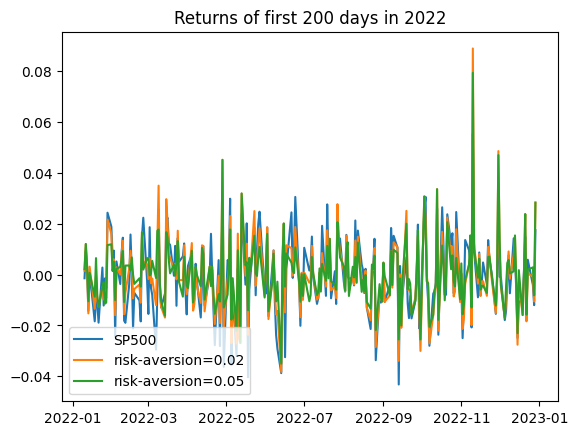

In [ ]:
# sp500 vs portfolio
# assets
#impart

SP500 = yf.download("^GSPC", datetime(2022, 1, 7), datetime(2022, 12, 31))['Adj Close']

SP500 = SP500.pct_change().dropna()[0:245]


x = SP500.index
plt.plot(x,SP500,label='SP500')

plt.plot(x,return_2, label='risk-aversion=0.02')
plt.plot(x,return_5, label='risk-aversion=0.05')
plt.legend(loc='lower left')
plt.title('Returns of first 200 days in 2022')
plt.show()

tickers = ['GLD','IBB','XLK','USO','AAPL']

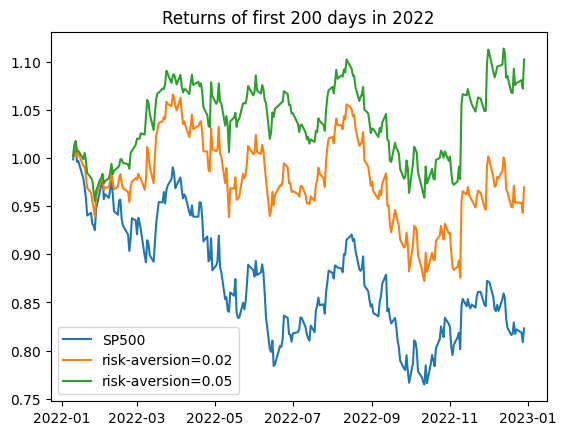

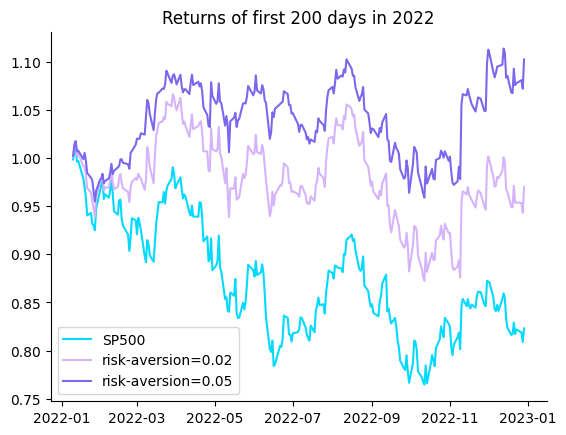

"\nplt.subplot(2,1,2)\nplt.plot(x,y1,'r')\nplt.plot(x,y2,'g')\n"

In [ ]:
from matplotlib.spines import Spine
sp = (SP500+1).cumprod()
my2 = (pd.Series(return_2)+1).cumprod()
my5 = (pd.Series(return_5)+1).cumprod()
plt.plot(x,sp,label='SP500')
#plt.plot(x,portfolio_ret[0:200], label='rebalanced portfolio')
plt.plot(x, my2, label='risk-aversion=0.02')
plt.plot(x, my5, label='risk-aversion=0.05')
plt.legend(loc='lower left')
plt.title('Returns of first 200 days in 2022')
plt.show()

#ax
#ax.spines['right'].set_visible(False)
fig, ax = plt.subplots(1,1)
plt.plot(x, sp, label='SP500', color = '#04d9ff')
plt.plot(x, my2, label='risk-aversion=0.02', color = '#d6b4fc')
plt.plot(x, my5, label='risk-aversion=0.05', color = 'mediumslateblue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='lower left')
plt.title('Returns of first 200 days in 2022')
plt.show()

'''
plt.subplot(2,1,2)
plt.plot(x,y1,'r')
plt.plot(x,y2,'g')
'''